# Document Alignment

Tutorial can be found [here](https://learnopencv.com/automatic-document-scanner-using-opencv/).

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
img = cv2.imread('../img/img22.jpg')

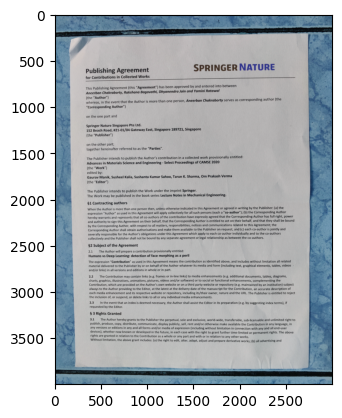

In [39]:
plt.imshow(img)

In [40]:
# Resize image to workable size
dim_limit = 1080
max_dim = max(img.shape)
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)

# Making copy of original image
orig_img = img.copy()

## Closing morphology operation

We will perform erosion and dilation operations on the image.

In [41]:
# Repeat closing operation to remove 'text' from the document.
kernel = np.ones((5,5), np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)

TypeError: imshow() missing 1 required positional argument: 'X'

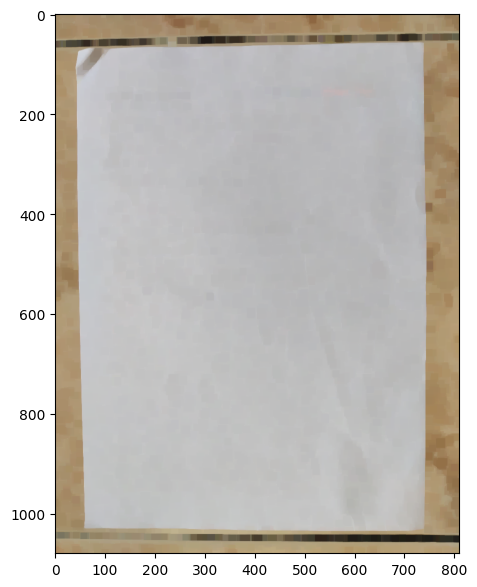

In [42]:
plt.figure(figsize=(10,7))
plt.imshow(img[:,:,::-1])
plt.imshow()

In [43]:
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel, fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

TypeError: imshow() missing 1 required positional argument: 'X'

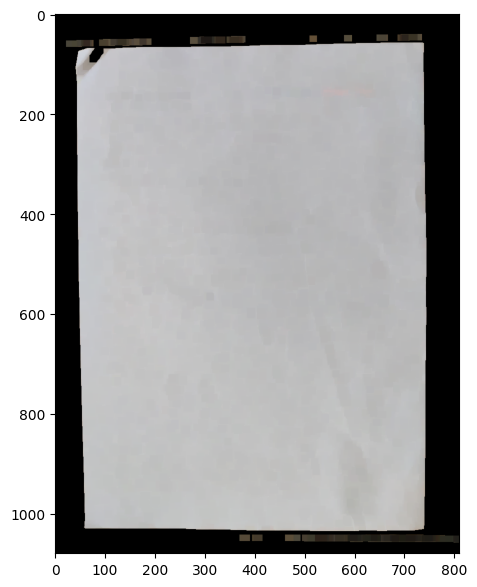

In [44]:
plt.figure(figsize=(10, 7))
plt.imshow(img[:, :, ::-1])
plt.imshow()


## Canny Edge detection

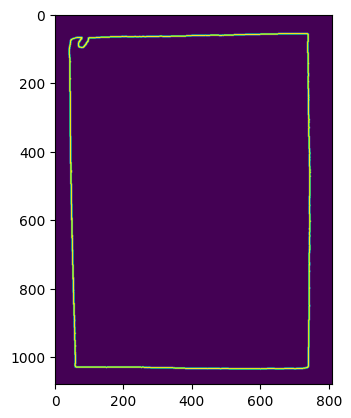

In [45]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge detection
canny = cv2.Canny(gray, 100, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
plt.imshow(canny)

## Contour detection

In [46]:
# Blank canvas
con = np.zeros_like(img)
# Finding contours for the detected edges
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the latest detected contour
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

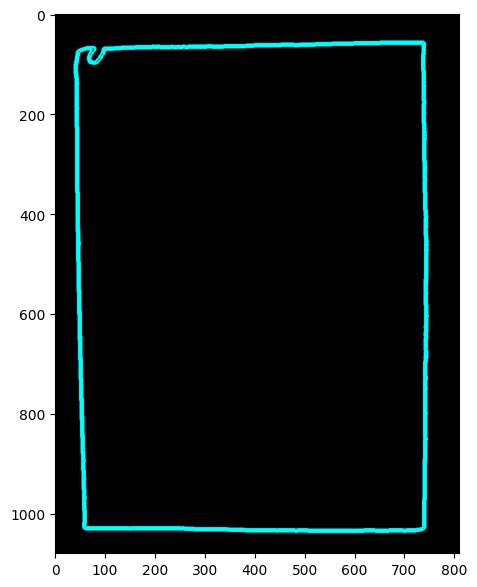

In [47]:
plt.figure(figsize=(10, 7))
plt.imshow(con)
plt.show()


## Corner detection using Douglas-Peucker algorithm

In [48]:
def order_points(pts):
    '''Rearrange coordinates to order:
       top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left point will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()


[[44, 74], [738, 56], [739, 1031], [58, 1031]]


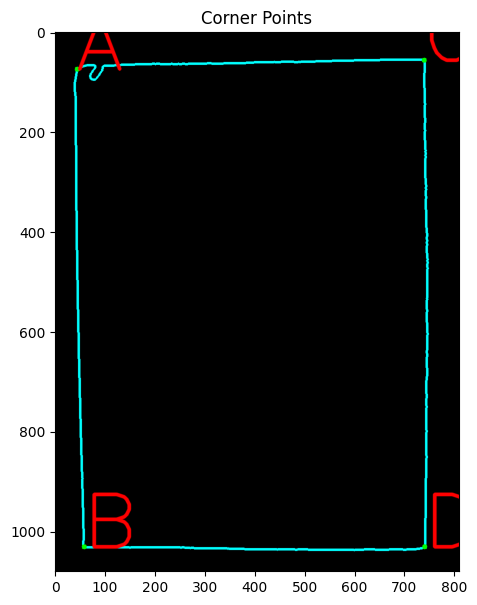

In [49]:
# Blank canvas
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
    # Approximate the contour.
	epsilon = 0.02 * cv2.arcLength(c, True)
	corners = cv2.approxPolyDP(c, epsilon, True)
	# If our approximated contour has four points
	if len(corners) == 4:
		break

cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# displaying corners
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 5, cv2.LINE_AA)

# rearranging the order of the corner points.
corners = order_points(corners)

print(corners)

plt.figure(figsize=(10, 7))
plt.imshow(con)
plt.title('Corner Points')
plt.show()

## Finding destination co-ordinates

In [50]:
(tl, tr, br, bl) = corners
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [
    [0, 0],
  		[maxWidth, 0],
  		[maxWidth, maxHeight],
  		[0, maxHeight]]
print(destination_corners)


[[0, 0], [694, 0], [694, 975], [0, 975]]


## Homography

In [51]:
# getting the homography
homography = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# perspective transform using homography
final = cv2.warpPerspective(orig_img, np.float32(homography), (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

Text(0.5, 1.0, 'Scanned Form')

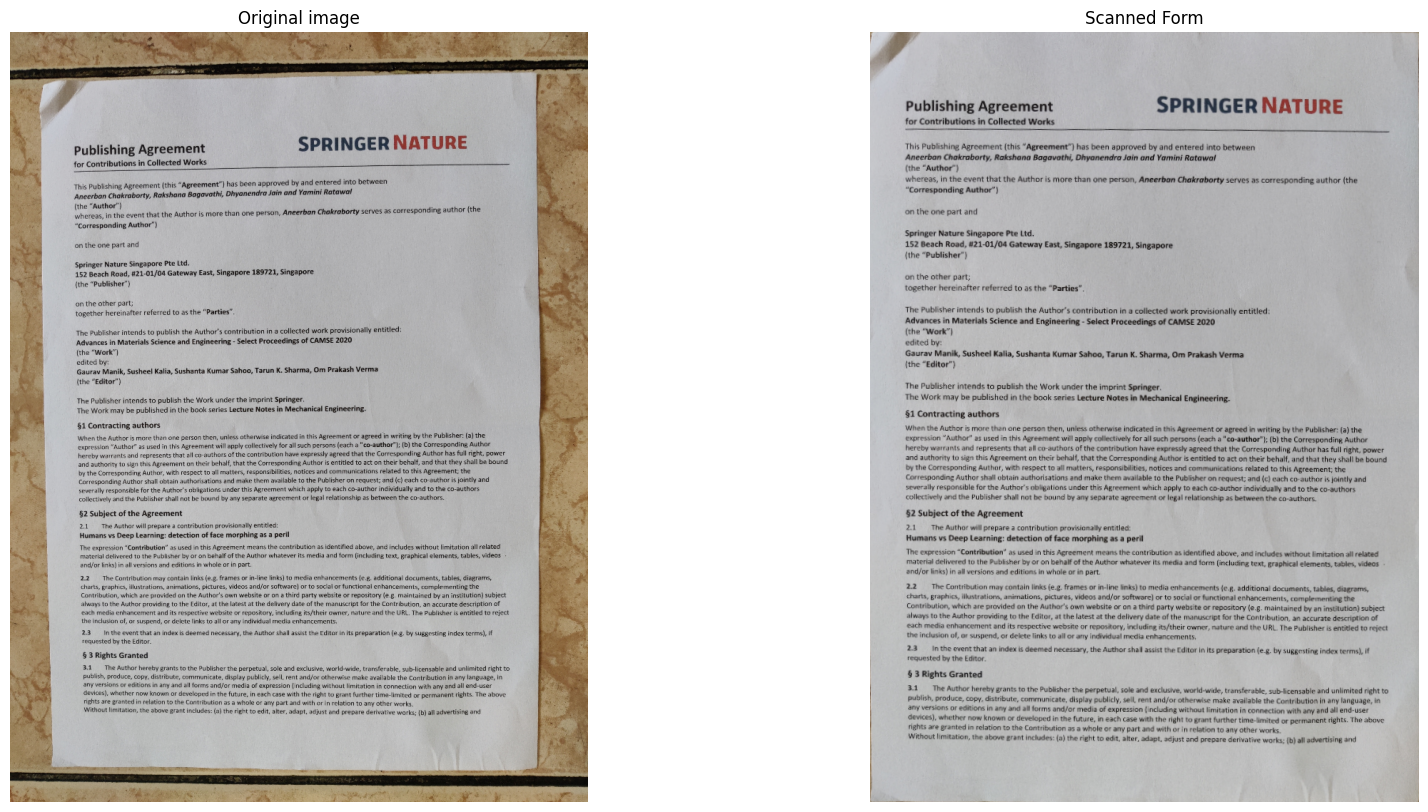

In [52]:
# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121)
plt.imshow(orig_img[:, :, ::-1])
plt.axis('off')
plt.title("Original image")
plt.subplot(122)
plt.imshow(final[:, :, ::-1])
plt.axis('off')
plt.title("Scanned Form")
